In [10]:
import requests
import re
from tqdm.notebook import tqdm
import requests
from bs4 import BeautifulSoup
import os

In [21]:
html = requests.get('https://russjcardiol.elpub.ru/jour/issue/archive').content

soup = BeautifulSoup(html, 'html.parser')
content = soup.find('div', {'id': 'issues'})
archive_by_year = content.find_all('div', {'class': 'archive'})

In [22]:
def cycle_archives(archives):
    lst = []
    for archive in tqdm(archives):
        links, numbers = get_issue_link(archive)
        lst.append((links, numbers))
    return lst

def get_2nd_level(link):
    page = requests.get(link).content
    soup = BeautifulSoup(page, 'html.parser')
    anchors = soup.find_all('div', {'class': 'tocGalleys'})
    if not anchors:
        print('No achors found for:', link)
        return
    for anchor in anchors:
        text = anchor.text.lower()
        if re.search(find_ru_pdf, text):
            pdf_viewer_link = anchor.find('a', {'class': 'file'}).get('href')
            return pdf_viewer_link

def get_3rd_level(link):
    page = requests.get(link).content
    soup = BeautifulSoup(page, 'html.parser')
    download_link = soup.find('a', {'class': 'action pdf'}).get('href')
    return download_link

In [24]:
# find_issue_number = re.compile(r'№ (\d+\w?)')
find_ru_pdf = re.compile(r'(pdf|pdf [(]rus[)])')

punct = re.compile('[\-.,:]')
mult_ws = re.compile('\s+')

def get_issue_link(issues):
    links, numbers = [], []
    anchors = issues.find_all('a')
    for anchor in tqdm(anchors):
        if 'Принято в печать' in anchor.text or not anchor.text:
            continue
        issue_number = re.sub(punct, ' ', anchor.text).lower().strip()
        issue_number = re.sub(mult_ws, '_', issue_number)
        link = anchor.get('href')
        if not link:
            print('!!!'+ str(anchor))
        try:
            pdf_viewer_link = get_2nd_level(link)
        except Exception as e:
            print(e.__class__.__name__)
            print(link)
            print()
        if pdf_viewer_link:
            download_link = get_3rd_level(pdf_viewer_link)
            links.append(download_link)
            numbers.append(issue_number)
    return links, numbers

In [25]:
%%time
res = cycle_archives(archive_by_year)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

https://russjcardiol.elpub.ru/jour/issue/view/192/showToc
https://russjcardiol.elpub.ru/jour/issue/view/186/showToc


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

https://russjcardiol.elpub.ru/jour/issue/view/45/showToc
https://russjcardiol.elpub.ru/jour/issue/view/113/showToc


  0%|          | 0/28 [00:00<?, ?it/s]

https://russjcardiol.elpub.ru/jour/issue/view/22/showToc
https://russjcardiol.elpub.ru/jour/issue/view/112/showToc
https://russjcardiol.elpub.ru/jour/issue/view/19/showToc


  0%|          | 0/32 [00:00<?, ?it/s]

https://russjcardiol.elpub.ru/jour/issue/view/111/showToc


  0%|          | 0/24 [00:00<?, ?it/s]

https://russjcardiol.elpub.ru/jour/issue/view/26/showToc
https://russjcardiol.elpub.ru/jour/issue/view/110/showToc
https://russjcardiol.elpub.ru/jour/issue/view/109/showToc
https://russjcardiol.elpub.ru/jour/issue/view/108/showToc
https://russjcardiol.elpub.ru/jour/issue/view/107/showToc
https://russjcardiol.elpub.ru/jour/issue/view/106/showToc
https://russjcardiol.elpub.ru/jour/issue/view/105/showToc


  0%|          | 0/22 [00:00<?, ?it/s]

https://russjcardiol.elpub.ru/jour/issue/view/102/showToc
https://russjcardiol.elpub.ru/jour/issue/view/101/showToc
https://russjcardiol.elpub.ru/jour/issue/view/100/showToc
https://russjcardiol.elpub.ru/jour/issue/view/99/showToc
https://russjcardiol.elpub.ru/jour/issue/view/98/showToc


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 12.3 s, sys: 197 ms, total: 12.5 s
Wall time: 4min 14s


In [29]:
def download_content(all_links):
    missing_links = []
    for row in tqdm(all_links):
        for link, number in zip(*row):
            with open(f'pdfs/{number}.pdf', 'wb') as fh:
                try:
                    content = requests.get(link).content
                    fh.write(content)
                except ConnectionResetError:
                    missing_links.append(link)
    if missing_links:
        return missing_links
    return

In [30]:
download_content(res)

  0%|          | 0/12 [00:00<?, ?it/s]

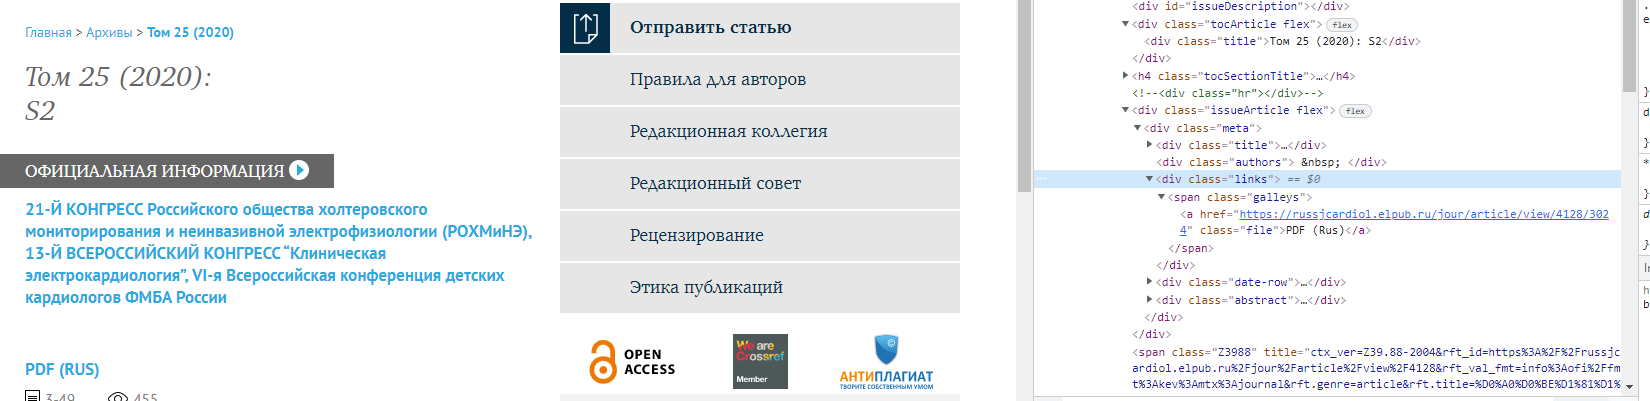

# ПРИМЕР

In [3]:
response = requests.get('https://russjcardiol.elpub.ru/jour/issue/download/206/212')

with open('pdfs/cardio.pdf', 'wb') as fh:
    fh.write(response.content)

In [30]:
import fitz

def extract_text_from_doc(path):
    doc = fitz.open(path)
    doc_pages = []
    for current_page in range(len(doc)):
        page = doc.load_page(current_page)
        page_text = page.get_text("text")
        doc_pages.append(page_text)
    return doc_pages

In [31]:
raw_doc = extract_text_from_doc('pdfs/cardio.pdf')

In [46]:
from typing import List

def concat_page(text: str, page_num: int) -> str:
    '''
    соединяет страницу (переносы слов) из представления fitz
    '''
    if not isinstance(text, str):
        raise TypeError('`text` should be a string')

    page_text = ''
    split_text = [sent for sent in text.split('\n') if sent]
    for i, raw_sent in enumerate(split_text):
        # пропускаем header "Росиийский кардиологический журнал / ОРИГИНАЛЬНЫЕ СТАТЬИ"
        if i == 0 or i == 1:
            continue

        tokens = raw_sent.split()
        if not tokens:  # tokens == []
            continue
        last_word = tokens[-1]

        # проверяем кейс, когда последнее слово на странице с переносом (para-...transit)
        if last_word.endswith('-') and len(last_word) > 1:
            page_text += ' '.join(tokens[:-1]) # не включаем последний (т.к. на странице картинки и таблицы переходят вниз)
        else:
            page_text += raw_sent + ' '
    page_text = page_text.strip()
    return page_text

In [33]:
# не убираем \n (по ним нужно убрать заголовок и подвалы)
mult_ws = re.compile(r'[ \t]+')

def little_preprocessing(text: str) -> str:
    text = text.replace('—', '-')
    text = text.replace('\xa0', ' ')
    text = text.replace('\uf0b7', ' ')
    text = text.replace('ё', 'е')
    text = re.sub(mult_ws, ' ', text)
    return text.strip()

def concat_doc(doc: List[str]) -> str:
    '''
    представляет документ в виде строки
    с их небольшим препроцессингом
    '''
    if not isinstance(doc, list):
        raise TypeError('`doc` should of type list')

    doc_text = ''
    for page_num, raw_page in enumerate(doc):
        page_little_prep = little_preprocessing(raw_page)
        page_text = concat_page(page_little_prep, page_num)
        # проверяем кейс, когда последнее слово на странице с переносом (para-...transit)
        # и правильно соединим данный токен с его частью на следующей странице
        if page_text:
            last_token_on_page = page_text.split()[-1]
            if last_token_on_page.endswith('-') and len(last_token_on_page) > 1:
                doc_text += page_text[:-1]
            else:
                doc_text += page_text
    return doc_text

In [38]:
txt = concat_doc(raw_doc)

with open('test.txt', 'w') as fh:
    fh.write(txt)

In [65]:
def concat_all_docs(source_dir: str) -> List:
    docs_concat = []
    for doc_name in tqdm(os.listdir(source_dir)):
        raw_doc = extract_text_from_doc(f'{source_dir}/{doc_name}')
        doc = concat_doc(raw_doc)
        docs_concat.append(doc)
    return docs_concat

In [66]:
docs = concat_all_docs('pdfs')

  0%|          | 0/128 [00:00<?, ?it/s]

### Сохраняем собранные тексты

In [108]:
def save_text(doc: List[str], filename: str = None, target_dir: str = 'txt') -> None:
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    with open(f'{target_dir}/{filename}.txt', 'w') as fh:
        fh.write(doc)

In [110]:
for doc, fname in zip(docs, os.listdir('pdfs')):
    fname = fname.split('.')[0]
    save_text(doc, fname)